
## Analytic Solutions Convergence Tests

This notebook runs series of simulations across different resolutions to extract error convergence information. Analytic Stokes flow solutions are used as a basis for error estimation. 


In [1]:
from collections import OrderedDict as OD
regress_solns = [
#   ("name", {soln_params},         {solver_tolerances},           graph_result )
    ("A",    OD(),                  {"itol":1.e-6, "otol":1.e-6},  True ),
    ("Cx",   OD(),                  {"itol":1.e-9, "otol":1.e-9},  True  ),
    ("Kx",   OD(),                  {"itol":1.e-4, "otol":1.e-4},  True ),
    ("NL",   OD(),                  {"itol":1.e-7, "otol":1.e-7},  True  ),
]

import os
if "UW_LONGTEST" in os.environ:
    regress_solns += [
    ("B",    OD(),                  {"itol":1.e-5, "otol":1.e-5},  False ),
    ("C",    OD(),                  {"itol":1.e-5, "otol":1.e-5},  False ),
    ("DA",   OD(),                  {"itol":1.e-7, "otol":1.e-7},  True  ),
    ("DB2d", OD(),                  {"itol":1.e-6, "otol":1.e-6},  True ),
    ("DB3d", OD(),                  {"itol":1.e-8, "otol":1.e-8},  True ),    
#     ("H",    OD([("nmodes",240),]), {"itol":1.e-6, "otol":1.e-6},  True  ),  # needs parallel for analytic
    ("Kz",   OD(),                  {"itol":1.e-4, "otol":1.e-4},  False ),
    ("M",    OD(),                  {"itol":1.e-6, "otol":1.e-6},  True ),        
    ]

graph_all   = True
two_d_only  = False
do_analysis = True
with_matplotlib = True

import underworld as uw
try:
    import matplotlib
    uw.utils.matplotlib_inline()
except ModuleNotFoundError:
    with_matplotlib = False

regress_res = [8,16,32]
orders      = [1,2]

if len(regress_res)<2:
    raise RuntimeError("At least 2 resolutions required for regression analysis.")

In [2]:
import underworld.visualisation as vis 
from underworld import function as fn
import math
import numpy as np
import collections

No module named 'lavavu' : module not found! disabling inline visualisation


In [3]:
# Find all available solutions. 
# Use ordered dict to preserve alphabetical ordering
solns_avail = collections.OrderedDict()
for soln_name in dir(fn.analytic):
    if soln_name[0] == "_": continue  # if private member, ignore
    # get soln class
    soln = getattr(fn.analytic,soln_name)
    # check if actually soln
    if issubclass(soln, fn.analytic._SolBase):
        print("Solution added: {}".format(soln_name))
        solns_avail[soln_name] = soln

Solution added: SolA
Solution added: SolB
Solution added: SolC
Solution added: SolCx
Solution added: SolDA
Solution added: SolDB2d
Solution added: SolDB3d
Solution added: SolH
Solution added: SolKx
Solution added: SolKz
Solution added: SolM
Solution added: SolNL


In [4]:
solns = collections.OrderedDict()
for sol in regress_solns:
    solname = "Sol"+sol[0]
    solns[solname] = solns_avail[solname.split(',')[0]](**sol[1])
    solns[solname].parameters = sol[1]   # record this for the table later
    solns[solname].tolerances = sol[2]   # record required tolerances as well
    solns[solname].graph      = True if graph_all else sol[3]   # record if should add to graph

In [5]:
# Create the tools we need

def get_numerical( soln, res=32, order=1, itol=1.e-6, otol=1.e-6 ):
    '''
    Creates the numerical system corresponding to the provided analytic system.
    
    Parameters
    ----------
    soln : uw.function.analytic._SolBase
        The analytic system
    res : int
        System resolution. Same resolution is used for each axis.
    order : int
        System numerical order. 
    itol : float
        Inner solve tolerance.
    otol : float
        Outer solve tolerance.

        
    '''
    if order == 1:
        els = "Q1/dQ0"
    elif order == 2:
        els = "Q2/dPc1"
    else:
        raise ValueError("Provided system order should be 1 or 2.")

    dim = soln.dim
    mesh  = uw.mesh.FeMesh_Cartesian(elementType=els, elementRes=(res,)*dim,minCoord=(0.,)*dim,maxCoord=(1.,)*dim)
    vel   = uw.mesh.MeshVariable(mesh,dim)
    press = uw.mesh.MeshVariable(mesh.subMesh, 1)
    vel.data[:]   = (0.,)*dim
    press.data[:] = 0.

    bcs = soln.get_bcs(vel)
    visc = soln.fn_viscosity
    if soln.nonlinear==True:
        visc = soln.get_viscosity_nl(vel,press)
    stokes = uw.systems.Stokes(vel, press, fn_viscosity=visc, fn_bodyforce=soln.fn_bodyforce, conditions=[bcs,])
    solver = uw.systems.Solver(stokes)
    if uw.mpi.size==1:
        solver.set_inner_method("lu")
    solver.set_inner_rtol(itol)
    solver.set_outer_rtol(otol)
    
    # if nonlinear, lets first grab a const visc approx soln
    if soln.nonlinear==True:
        stokes.fn_viscosity = 1.
        solver.solve()
        stokes.fn_viscosity = visc

    return mesh, vel, press, solver

def normalise_press(press):
    intSwarm = uw.swarm.GaussIntegrationSwarm(mesh,3)  # use 3 point gauss swarms for efficiency
    av_press = uw.utils.Integral( press, mesh, integrationSwarm=intSwarm, integrationType=None).evaluate()[0]
    
    return press - av_press

def rms_error(numeric, analytic, mesh):
    '''
    Calculates the rms error.
    
    Returns
    -------
    abs, abs_scaled: float
        The absolute and scaled absolute errors.
    '''

    delta     = analytic - numeric
    delta_dot = fn.math.dot(delta,delta)

    analytic_dot = fn.math.dot(analytic,analytic)
    
    # l2 norms
    intSwarm = uw.swarm.GaussIntegrationSwarm(mesh,3)  # use 3 point gauss swarms for efficiency
    rms_err_abs = np.sqrt(uw.utils.Integral(    delta_dot, mesh, integrationSwarm=intSwarm, integrationType=None ).evaluate()[0])
    rms_sol_ana = np.sqrt(uw.utils.Integral( analytic_dot, mesh, integrationSwarm=intSwarm, integrationType=None ).evaluate()[0])
    rms_err_sca = rms_err_abs / rms_sol_ana
        
    return rms_err_abs, rms_err_sca

### Now perform convergence rate tests 

In [6]:
velocity_key = "Velocity"
pressure_key = "Pressure"

resolutions = regress_res
dx = np.reciprocal(resolutions,dtype='double')

In [7]:
soln_results = collections.OrderedDict()

for soln_name in solns.keys():
    solnguy = solns[soln_name]
    if (solnguy.dim == 3) and two_d_only:
        continue
    for order in orders:
        if (soln_name,order,velocity_key) in soln_results:
            err_pre = soln_results[ (soln_name,order,pressure_key) ]
            err_vel = soln_results[ (soln_name,order,velocity_key) ]
        else:
            err_pre = collections.OrderedDict()
            err_vel = collections.OrderedDict()



        for res in resolutions:
            # use lower res for 3d. 
            dim = solnguy.dim
            if dim==3:
                res = round(res/2.)
            # do not rerun existing results
            if res in err_vel:
                continue
            mesh, vel, press, solver = get_numerical( solnguy, res, order=order, **solnguy.tolerances )

            if uw.mpi.rank==0: print("Performing simulations for solution: {} {} {}".format(soln_name, order, res), flush=True)

            if solnguy.nonlinear!=True:
                solver.solve()
            else:
                solver.solve(nonLinearIterate=True,nonLinearTolerance=1.e-7)

            pressn = normalise_press(press)
            pressa = normalise_press(solnguy.fn_pressure)

            err_vel[res] = rms_error(    vel, solnguy.fn_velocity, mesh )
            err_pre[res] = rms_error( pressn,              pressa, mesh )

            # lets store these for future comparison
            err_vel.parameters = solnguy.parameters
            err_vel.tolerances = solnguy.tolerances

            soln_results[(soln_name,order,velocity_key)] = err_vel
            soln_results[(soln_name,order,pressure_key)] = err_pre

	Global element size: 8x8
	Local offset of rank 0: 0x0
	Local range of rank 0: 8x8
Performing simulations for solution: SolA 1 8
Linear solver (DLJ1OG4R__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 8.447e-06 secs / 1 its
  Pressure Solve:         = 1.992e-05 secs / 1 its
  Final V Solve:          = 3.818e-06 secs / 1 its

  Total BSSCR Linear solve time: 0.000398 seconds

Linear solver (DLJ1OG4R__system-execute), solution time 8.237810e-04 (secs)
	Global element size: 16x16
	Local offset of rank 0: 0x0
	Local range of rank 0: 16x16
Performing simulations for solution: SolA 1 16
Linear solver (9L5WSXDF__system-execute) 

BSSCR -- Block Stokes Schur Compliment Reduction Solver 
AUGMENTED LAGRANGIAN K2 METHOD - Penalty = 0.000000

  Setting schur_pc to "uw" 


SCR Solver Summary:

  RHS V Solve:            = 2.711e-05 secs / 1 i

Performing analysis.


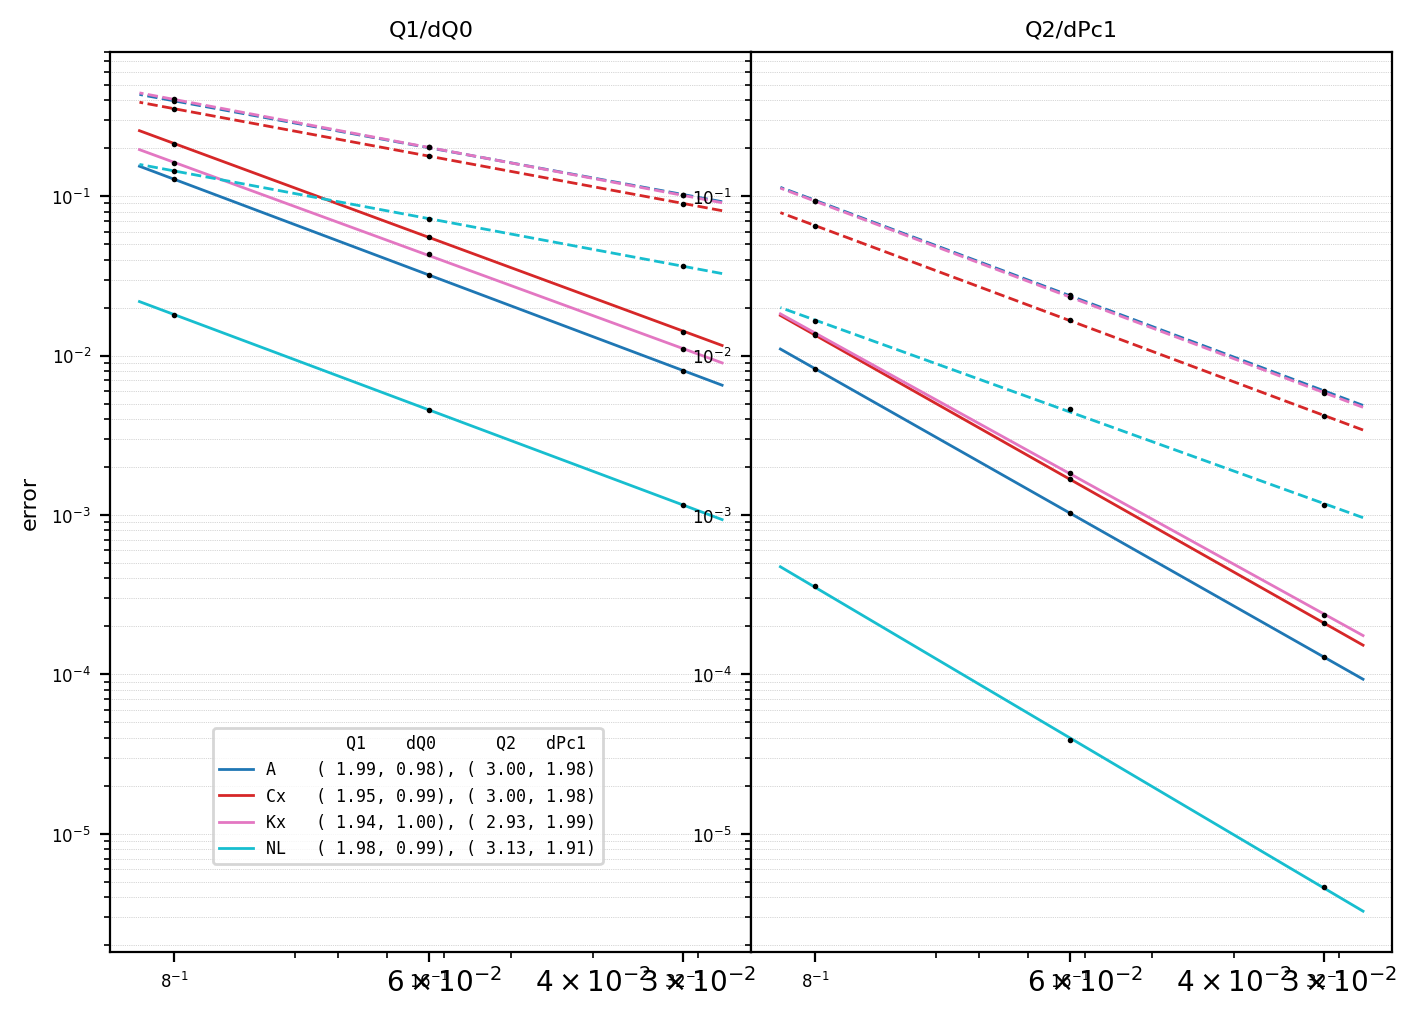

In [8]:
if (uw.mpi.rank==0) and do_analysis:
    err_messages = []
    print("Performing analysis.", flush=True)

    errtype = 1  # {0:"absolute", 1:"scaled absolute"}
    
    fitfn = lambda x,a,b: a+b*x
    def get_linear_fit(x,y):
        '''
        Returns best fit (a,b) for $ln(y)=a+b*ln(x)$ for provided
        set of points (x,y).
        '''
        import scipy.optimize
        return scipy.optimize.curve_fit(fitfn,  np.log(x),  np.log(y))

    def get_fit_line(dx, fit):
        '''
        Evaluates fit across a set of points.
        '''
        dxmin = 0.9*dx.min()
        dxmax = 1.1*dx.max()
        xpts = np.linspace(dxmin,dxmax,20)
        ypts = np.exp(fitfn(np.log(xpts),*fit))
        return xpts, ypts

    if with_matplotlib:
        import matplotlib.pyplot as plt
        fig = plt.figure(dpi=200, figsize=(8.27, 11.69/2.))
        plt.subplots_adjust(wspace=.0)

        # create some consistent colours & linestyles
        from matplotlib.pyplot import cm
        colours = cm.tab10(np.linspace(0,1,len(solns.keys())))
        scheme = {}
        for it,sol in enumerate(solns.keys()):
            scheme[(sol,pressure_key)] = (colours[it],'--')
            scheme[(sol,velocity_key)] = (colours[it],'-')


        def create_ax(pos, title=None, other_ax=None):
            ax = plt.subplot(1,2,pos,xscale='log', yscale='log', sharey=other_ax)
            ax.set_title(title,fontsize=8)
            ax.invert_xaxis()
            ax.xaxis.set_ticks(dx)
            ax.xaxis.set_ticklabels(["$ {{ {} }}^{{-1}}$".format(x) for x in resolutions])
            ax.grid(axis="y", which="both",linestyle=':',linewidth=0.25)
            ax.tick_params(axis='both', which='major', labelsize=8)
    #         ax.set_xlabel("dx", fontsize=8)
            if not other_ax:
                ax.set_ylabel("error", fontsize=8)

            # disable minor ticks marks on axis
            for tic in ax.xaxis.get_minor_ticks() + ax.yaxis.get_minor_ticks():
                tic.tick1On = tic.tick2On = False
                tic.label1On = tic.label2On = False
            for tic in ax.xaxis.get_major_ticks() + ax.yaxis.get_major_ticks():
                tic.label1.set_fontsize(6)
            # disable tick marks on rhs of other axis
            if other_ax:
                for tic in ax.yaxis.get_major_ticks():
                    tic.tick1On = tic.tick2On = False
                    tic.label1On = tic.label2On = False
            return ax

        axes = {}
        axes[1] = create_ax(1, title="Q1/dQ0")
        axes[2] = create_ax(2, title="Q2/dPc1", other_ax=axes[1] )

    # get fit results now so we can set plot labels
    fits = {}
    errs = {}
    for key, err in soln_results.items():
        soln_name = key[0]
        if (soln_name not in solns): #or (solns[soln_name].graph==False):
            continue

        fits[key], errs[key] = get_linear_fit(np.reciprocal(list(err.keys()),dtype='double'), [errval[errtype] for errval in err.values()] )

    # keep set of lines for legend
    lines = collections.OrderedDict()
    for key, err in sorted(soln_results.items(), key=lambda x: x[0][0]):
        soln_name = key[0]
        order     = key[1]
        velpres   = key[2]
        fit       = fits[key]
        fitdata   = get_fit_line(np.reciprocal(list(err.keys()),dtype='double'),fit)    

        expected_order = order if (key[2]==pressure_key) else order+1
        if not np.isclose(fit[1],expected_order,rtol=2.e-1):
            err_messages.append("Rejecting {} fit = {}, expected = {}.".format(soln_name,fit[1],expected_order))

        if (soln_name not in solns) or (solns[soln_name].graph==False):
            continue

        
        if with_matplotlib:
            ax     = axes[order]
            col,ls = scheme[(soln_name,velpres)]
            line = ax.plot(*fitdata, linewidth=1., color=col, linestyle=ls)
            if velpres == velocity_key:
                lines[soln_name] = line

            ax.plot(np.reciprocal(list(err.keys()),dtype='double'), [errval[errtype] for errval in err.values()], 'o', markersize=1., color='black')

    lbls = []
    lns = []
    for soln_name in lines.keys():
        vel_1   = fits[(soln_name,1,velocity_key)][1]
        pre_1   = fits[(soln_name,1,pressure_key)][1]
        vel_2   = fits[(soln_name,2,velocity_key)][1]
        pre_2   = fits[(soln_name,2,pressure_key)][1]
        lbls.append("{} ({: .2f},{: .2f}), ({: .2f},{: .2f})".format(soln_name[3:].ljust(4), vel_1, pre_1, vel_2, pre_2))
        lns.append(lines[soln_name][0])
    
    if with_matplotlib:
        leg = fig.legend( lns, lbls, loc = (0.15, 0.15), prop={'family': 'monospace', 'size':6})
        leg.set_title("Q1    dQ0      Q2   dPc1 ", 
                      {'family': 'monospace', 'size':6 })
        leg._legend_box.align = "right"
    
        fig.savefig("Analytic_Convergence_Graph.png")

In [9]:
if len(err_messages)>0:
    for err in err_messages:
        print(err)
    raise RuntimeError("Not all configurations produced the expected convergence rates.")